In [ ]:
# English Tweets with Logistic Regression

In [ ]:
import pandas as pd
import numpy as np

train_en = pd.read_csv("NTCIR-13_MedWeb_en_training.csv")
test_en = pd.read_csv("NTCIR-13_MedWeb_en_test.csv")

In [ ]:
# remove punctuation inside
import re
def  clean_text_en(df, text_field): 
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [ ]:
# update 
train_en = clean_text_en(train_en,"Tweet")
test_en = clean_text_en(test_en,"Tweet")

In [ ]:
# lemmatization
import spacy
from vectorizers import SpacyLemmatizer

import en_core_web_sm
nlp = en_core_web_sm.load()

lemmatizer = SpacyLemmatizer(nlp, join_str=' ', n_threads=1)
lemmas_train = lemmatizer(list(train_en.Tweet)) 
tweet_train_en = list(lemmas_train)

lemmas_test = lemmatizer(list(test_en.Tweet))
tweet_test_en = list(lemmas_test)

In [ ]:
# add stopwords
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
stop.extend('haha ugghh ugh uh um oh ok okay boo damn god yu yike yen yay mikos mitsuru shirasu lol sigh 10 100 10000 1004 102 104 320000 968' .split())

In [ ]:
categories = ['Influenza','Diarrhea','Hayfever','Cough','Headache','Fever','Runnynose','Cold']

y_train_en = train_en[categories].replace({'n':0, 'p':+1})
y_test_en = test_en[categories].replace({'n':0, 'p':+1})

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=set(stop))
X_train = vectorizer.fit_transform(tweet_train_en).toarray()

feature_en = vectorizer.get_feature_names()

vectorizer_test = CountVectorizer(vocabulary=vectorizer.vocabulary_)
X_test = vectorizer_test.transform(tweet_test_en).toarray()

print("The vocabulary contains {} unique tokens".format(len(feature_en)))

In [ ]:
# check reassons for Hayfever
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [10]}
grid = GridSearchCV(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=2500, class_weight='balanced'), param_grid, cv=5) # scoring='roc_auc'
grid.fit(X_train, y_train_en["Hayfever"].values)

import matplotlib.pyplot as plt
import mglearn
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_en, n_top_features=25)
plt.savefig("hayfever1Eng")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier


# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=2500, class_weight='balanced'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} sysptoms...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train_en[category].values)
    
    # calculating test accuracy
    prediction_en = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test_en[category], prediction_en)))
    print('Test precision is {}'.format(precision_score(y_test_en[category], prediction_en, average='binary')))
    print('Test recall is {}'.format(recall_score(y_test_en[category], prediction_en, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_test_en[category], prediction_en, average='binary')))

In [ ]:
print("Grid-search for best parameter in Logistic Regression >>")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model_to_set = OneVsRestClassifier(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=2500, class_weight='balanced'))
param_grid = {'estimator__C': [ 0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(model_to_set, param_grid, scoring='f1_weighted',cv=5) # scoring='roc_auc'
grid.fit(X_train, y_train_en)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0),
    LinearSVC(C= 10),
    MultinomialNB(),
    LogisticRegression(C = 10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train_en["Cold"], scoring='accuracy', cv=5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
plt.savefig("CV_ZH.jpg")

In [ ]:
# Chinese Tweets with Logistic Regression

In [1]:
import pandas as pd
import numpy as np

train_zh = pd.read_csv("NTCIR-13_MedWeb_zh_training.csv", na_values='NaN',keep_default_na=False)
test_zh = pd.read_csv("NTCIR-13_MedWeb_zh_test.csv", na_values='NaN',keep_default_na=False)
test_zh = test_zh[:640]

In [2]:
# remove punctuation inside
import re
from zhon.hanzi import punctuation

def clean_text_zh(df, text_field):
    
    df[text_field] = df[text_field].apply(lambda elem:re.sub(r'[{}]+'.format(punctuation),'',elem))
    
    return df

In [3]:
# update 
train_zh = clean_text_zh(train_zh,"Tweet")
test_zh = clean_text_zh(test_zh,"Tweet")

tweet_train_zh = list(train_zh.Tweet)
tweet_test_zh = list(test_zh.Tweet)

In [4]:
# introducing tokenizer
import jieba

def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = [' ','！','？','、','。','〜','…','《','“','”','1','100','3','32','36','38','39','40',
              'ok','了']
vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stop_words)
X_train_zh = vectorizer.fit_transform(tweet_train_zh).toarray()

feature_zh = vectorizer.get_feature_names()

vectorizer_test = CountVectorizer(vocabulary=vectorizer.vocabulary_)
X_test_zh = vectorizer.transform(tweet_test_zh).toarray()

print("The vocabulary contains {} unique tokens".format(len(feature_zh)))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/xz/jrlb55l167x3c2jq466bx5fm0000gn/T/jieba.cache
Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


The vocabulary contains 2281 unique tokens


In [6]:
categories = ['Influenza','Diarrhea','Hayfever','Cough','Headache','Fever','Runnynose','Cold']

y_train_zh = train_zh[categories].replace({'n':0, 'p':+1})
y_test_zh = test_zh[categories].replace({'n':0, 'p':+1})

In [ ]:
np.set_printoptions(threshold=np.inf) 

In [8]:
# check reassons for Hayfever
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [10]}
grid = GridSearchCV(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=2500, class_weight='balanced'), param_grid, cv=5) # scoring='roc_auc'
grid.fit(X_train_zh, y_train_zh["Hayfever"].values)

import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['axes.unicode_minus']=False 

import mglearn
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_zh, n_top_features=25)
plt.savefig("hayfever1Zh")

/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier


# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=4000, class_weight='balanced'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} sysptoms...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train_zh, y_train_zh[category].values)
    
    # calculating test accuracy
    prediction_zh = LogReg_pipeline.predict(X_test_zh)
    print('Test accuracy is {}'.format(accuracy_score(y_test_zh[category], prediction_zh)))
    print('Test precision is {}'.format(precision_score(y_test_zh[category], prediction_zh, average='binary')))
    print('Test recall is {}'.format(recall_score(y_test_zh[category], prediction_zh, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_test_zh[category], prediction_zh, average='binary')))

**Processing Influenza sysptoms...**
Test accuracy is 0.9671875
Test precision is 0.5405405405405406
Test recall is 0.8333333333333334
Test f1-score is 0.6557377049180328

**Processing Diarrhea sysptoms...**
Test accuracy is 0.9765625
Test precision is 0.8356164383561644
Test recall is 0.953125
Test f1-score is 0.8905109489051095

**Processing Hayfever sysptoms...**
Test accuracy is 0.975
Test precision is 0.7678571428571429
Test recall is 0.9347826086956522
Test f1-score is 0.8431372549019608

**Processing Cough sysptoms...**
Test accuracy is 0.9796875
Test precision is 0.9135802469135802
Test recall is 0.925
Test f1-score is 0.9192546583850932

**Processing Headache sysptoms...**
Test accuracy is 0.9765625
Test precision is 0.8780487804878049
Test recall is 0.935064935064935
Test f1-score is 0.9056603773584906

**Processing Fever sysptoms...**
Test accuracy is 0.94375
Test precision is 0.7663551401869159
Test recall is 0.8817204301075269
Test f1-score is 0.82

**Processing Runnynose 

In [10]:
print("Grid-search for best parameter in Logistic Regression >>")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model_to_set = OneVsRestClassifier(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=2500, class_weight='balanced'))
param_grid = {'estimator__C': [ 0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(model_to_set, param_grid, scoring='f1_weighted',cv=5) # scoring='roc_auc'
grid.fit(X_train_zh, y_train_zh)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Grid-search for best parameter in Logistic Regression >>
Best cross-validation score: 0.86
Best parameters:  {'estimator__C': 10}


/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

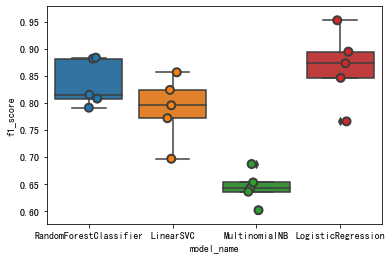

In [36]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0),
    LinearSVC(C= 0.01),
    MultinomialNB(),
    LogisticRegression(C = 10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_zh, y_train_zh["Cold"], scoring='f1', cv=5)
    for fold_idx, f1_score in enumerate(f1_scores):
        entries.append((model_name, fold_idx, f1_score))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])
import seaborn as sns
sns.boxplot(x='model_name', y='f1_score', data=cv_df)
sns.stripplot(x='model_name', y='f1_score', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.ylim=(0.5,1.0)
plt.savefig("CVZHF1.jpg")
plt.show()


/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

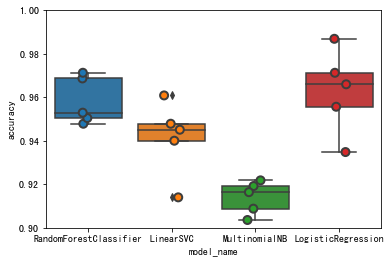

In [38]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0),
    LinearSVC(C= 0.01),
    MultinomialNB(),
    LogisticRegression(C = 10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_zh, y_train_zh["Cold"], scoring='accuracy', cv=5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
axes = plt.axes()
axes.set_ylim([0.9,1.0])
plt.savefig("CVZHACC.jpg")
plt.show()

In [ ]:
# Japanese Tweets with Logistic Regression

In [14]:
import pandas as pd
import numpy as np

train_ja = pd.read_csv("NTCIR-13_MedWeb_ja_training.csv", na_values='NaN',keep_default_na=False)
test_ja = pd.read_csv("NTCIR-13_MedWeb_ja_test.csv", na_values='NaN',keep_default_na=False)


In [15]:
# remove punctuation inside
import re
from zhon.hanzi import punctuation

def clean_text_ja(df, text_field):
    
    df[text_field] = df[text_field].apply(lambda elem:re.sub(r'[{}]+'.format(punctuation),'',elem))
    
    return df

In [16]:
# update 
train_ja = clean_text_ja(train_ja,"Tweet")
test_ja = clean_text_ja(test_ja,"Tweet")

tweet_train_ja = list(train_ja.Tweet)
tweet_test_ja = list(test_ja.Tweet)

In [17]:
# Add Japanese tokenizer
import nagisa

def tokenize_jp(doc):
    doc = nagisa.tagging(doc)
    return doc.words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = ['!','0','1','2','3','4','6','8','9','?','、','。','〜','・']
vectorizer = CountVectorizer(tokenizer=tokenize_jp, stop_words=stop_words)
X_train_ja = vectorizer.fit_transform(tweet_train_ja).toarray()

feature_ja = vectorizer.get_feature_names()

vectorizer_test = CountVectorizer(tokenizer=tokenize_jp,vocabulary=vectorizer.vocabulary_)
X_test_ja = vectorizer_test.transform(tweet_test_ja).toarray()

print("The vocabulary contains {} unique tokens".format(len(feature_ja)))

The vocabulary contains 2152 unique tokens


In [19]:
categories = ['Influenza','Diarrhea','Hayfever','Cough','Headache','Fever','Runnynose','Cold']

y_train_ja = train_ja[categories].replace({'n':0, 'p':+1})
y_test_ja = test_ja[categories].replace({'n':0, 'p':+1})

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier


# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(C=10, solver='lbfgs', penalty='l2', max_iter=4000, class_weight='balanced'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} sysptoms...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train_ja, y_train_ja[category].values)
    
    # calculating test accuracy
    prediction_ja = LogReg_pipeline.predict(X_test_ja)
    print('Test accuracy is {}'.format(accuracy_score(y_test_ja[category], prediction_ja)))
    print('Test precision is {}'.format(precision_score(y_test_ja[category], prediction_ja, average='binary')))
    print('Test recall is {}'.format(recall_score(y_test_ja[category], prediction_ja, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_test_ja[category], prediction_ja, average='binary')))

**Processing Influenza sysptoms...**
Test accuracy is 0.9703125
Test precision is 0.5641025641025641
Test recall is 0.9166666666666666
Test f1-score is 0.6984126984126983

**Processing Diarrhea sysptoms...**
Test accuracy is 0.9828125
Test precision is 0.8732394366197183
Test recall is 0.96875
Test f1-score is 0.9185185185185184

**Processing Hayfever sysptoms...**
Test accuracy is 0.98125
Test precision is 0.8269230769230769
Test recall is 0.9347826086956522
Test f1-score is 0.8775510204081632

**Processing Cough sysptoms...**
Test accuracy is 0.9828125
Test precision is 0.9156626506024096
Test recall is 0.95
Test f1-score is 0.9325153374233127

**Processing Headache sysptoms...**
Test accuracy is 0.9875
Test precision is 0.9367088607594937
Test recall is 0.961038961038961
Test f1-score is 0.9487179487179488

**Processing Fever sysptoms...**
Test accuracy is 0.93125
Test precision is 0.7168141592920354
Test recall is 0.8709677419354839
Test f1-score is 0.7864077669902911

**Processing

/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

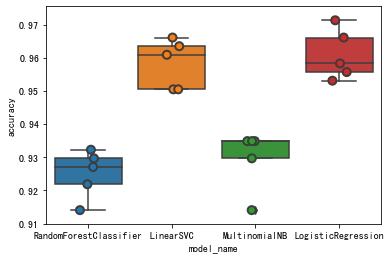

In [43]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0),
    LinearSVC(C= 10),
    MultinomialNB(),
    LogisticRegression(C = 10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_ja, y_train_ja["Cold"], scoring='accuracy', cv=5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.ylim=(0.5,1.0)
plt.savefig("CVJACC.jpg")
plt.show()

/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/boxulu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

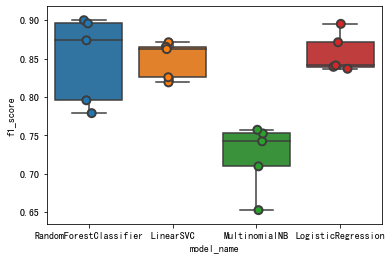

In [44]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0),
    LinearSVC(C= 15),
    MultinomialNB(),
    LogisticRegression(C = 10),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_ja, y_train_ja["Cold"], scoring='f1', cv=5)
    for fold_idx, f1_score in enumerate(f1_scores):
        entries.append((model_name, fold_idx, f1_score))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])
import seaborn as sns
sns.boxplot(x='model_name', y='f1_score', data=cv_df)
sns.stripplot(x='model_name', y='f1_score', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)


plt.savefig("CVJAF1.jpg")
plt.show()